## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Make sure to change path if you put the zip elsewhere
#!unzip drive/MyDrive/chest_xray.zip

## Create dataset from directory

In [2]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


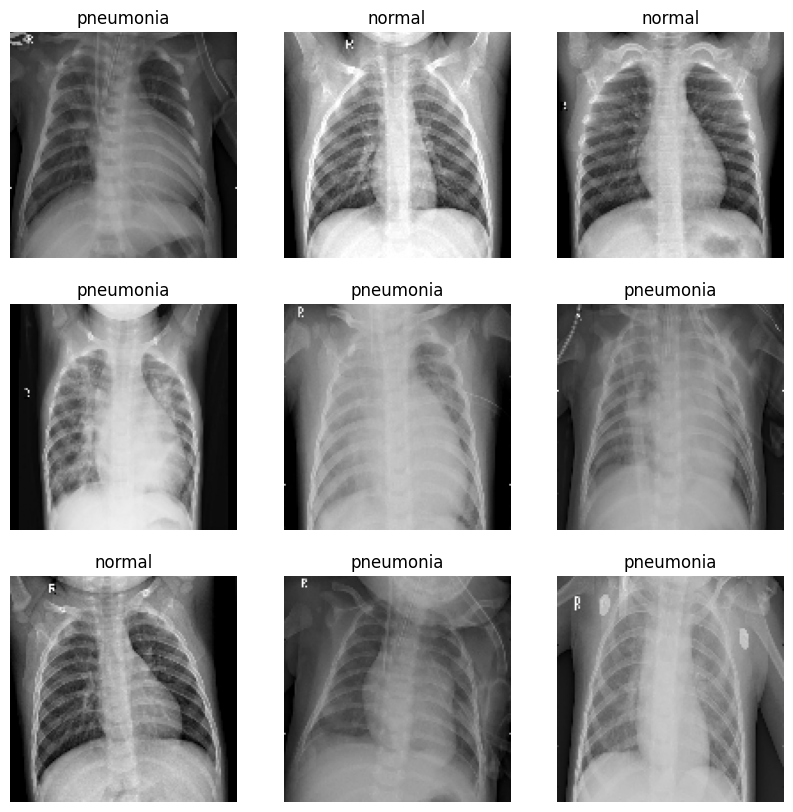

2025-11-26 15:17:37.073289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [4]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

2025-11-26 15:17:41.601204: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
class_weights

{0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}

## Create CNN model

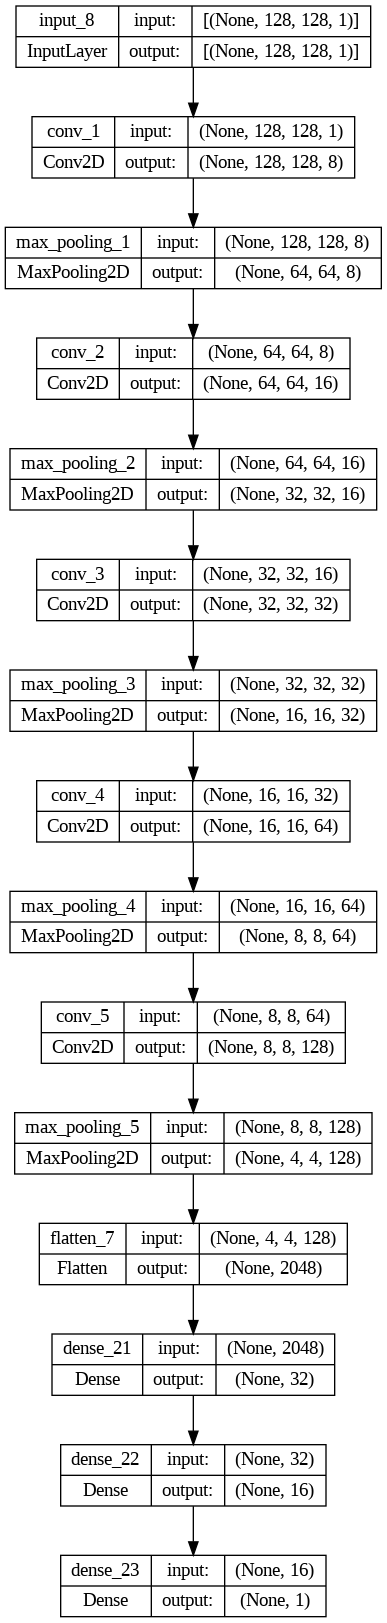

In [6]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.
conv_1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input)
max_pooling_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_1')(conv_1)

conv_2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_2')(conv_2)

conv_3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(max_pooling_2)    
max_pooling_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_3')(conv_3)

conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(max_pooling_3)    
max_pooling_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_4')(conv_4)

conv_5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(max_pooling_4)    
max_pooling_5 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_5')(conv_5)

flatten_7 = Flatten(name='flatten_7')(max_pooling_5)


dense_21 = Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = Dense(16, activation='relu', name='dense_22')(dense_21)

cnn_output = layers.Dense(1, activation='sigmoid')(dense_22)
cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [10]:
!pip install pydot


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [11]:

from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [13]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7916 - loss: 0.5258 - val_accuracy: 0.8125 - val_loss: 0.4222
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9465 - loss: 0.1331 - val_accuracy: 0.7500 - val_loss: 0.4322
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9626 - loss: 0.0934 - val_accuracy: 0.7500 - val_loss: 0.3304
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.9755 - loss: 0.0680 - val_accuracy: 1.0000 - val_loss: 0.0450
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9764 - loss: 0.0590 - val_accuracy: 1.0000 - val_loss: 0.0274


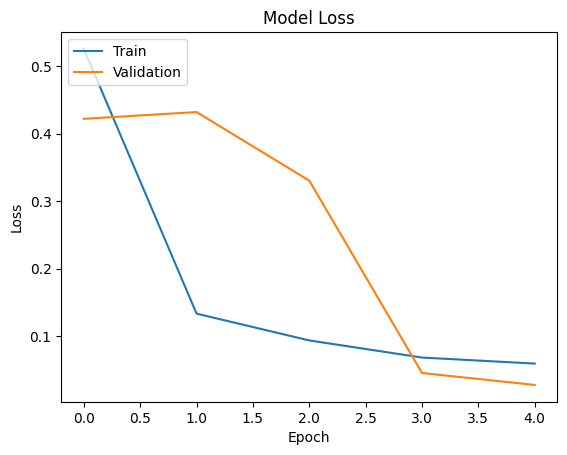

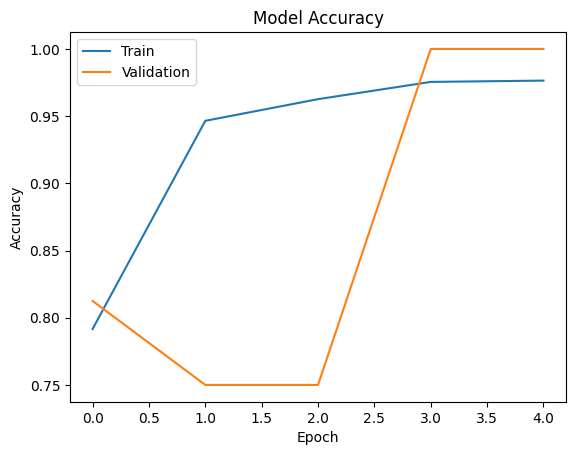

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
%pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


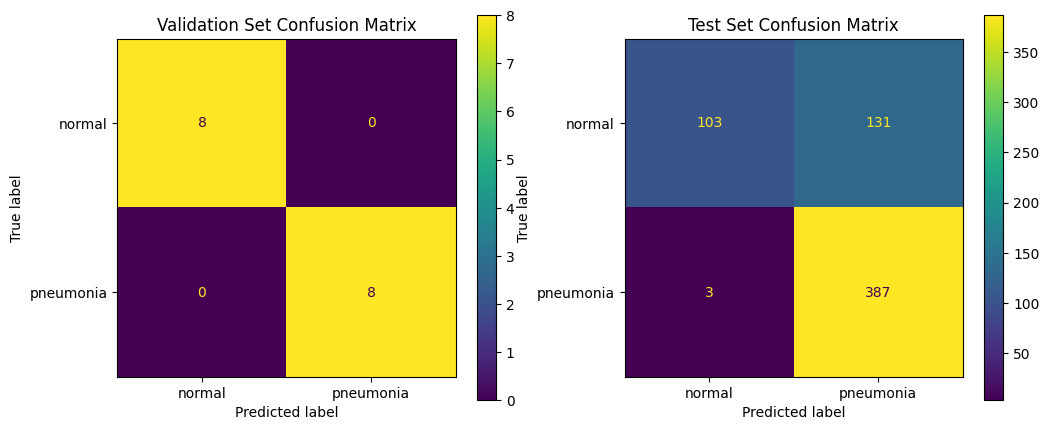

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []
# Added test set
test_images = []
test_labels = []

# Collect validation images and labels
for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)
val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# Collect test images and labels
for img, label in test_ds:
  test_images.append(img)
  test_labels.append(label)
test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set
from sklearn.metrics import confusion_matrix

# Get predictions
val_prediction = cnn.predict(val_images).squeeze().round().astype(int)
test_prediction = cnn.predict(test_images).squeeze().round().astype(int)

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_prediction)
cm_test = confusion_matrix(test_labels, test_prediction)


# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Create subplots for validation and test confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'])
disp.plot(ax=axes[0])
disp.ax_.set_title('Validation Set Confusion Matrix')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['normal', 'pneumonia'])
disp_test.plot(ax=axes[1])
disp_test.ax_.set_title('Test Set Confusion Matrix')
plt.show()




In [20]:
from sklearn.metrics import f1_score, accuracy_score
print("f1 score validation :", f1_score(val_labels, val_prediction))
print("accuracy validation :", accuracy_score(val_labels, val_prediction))
print("f1 score test :", f1_score(test_labels, test_prediction))
print("accuracy test :", accuracy_score(test_labels, test_prediction))

f1 score validation : 1.0
accuracy validation : 1.0
f1 score test : 0.8524229074889867
accuracy test : 0.7852564102564102
